# Named entity recognition

In [1]:
import os
import requests
import nltk.data
import re
import json
import time
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

### 1. Sort bills according to their size and take top 50 (largest) bills.

In [2]:
bills_path = '../../ustawy'
bills_files = []
top50_bills = []
for root, directories, files in os.walk(bills_path):
    for file_name in files:
        if file_name.endswith('.txt'):
            bills_files.append(os.path.join(root, file_name))
        
bills_files.sort(key=lambda f: os.stat(f).st_size, reverse=True)
top50_bills = bills_files[:50]

In [3]:
administration = [
        "dz.urz",  
        "póź.zm",
        "rej",  
        "sygn",  
        "Dz.U",  
        "woj",  
        "ozn",  
        "ust",  
        "ref",  
        "dz",
        "akt",  
    ]

extra_abbreviations = (
    administration
)

sentence_tokenizer = nltk.data.load('tokenizers/punkt/polish.pickle')
sentence_tokenizer._params.abbrev_types.update(extra_abbreviations)

### 2. Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence. Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [4]:
capitalized = {}

for bill in top50_bills:
    with open(bill, encoding='utf-8') as file:
        reader = file.read()
        reader = reader.replace('\n', ' ')
        reader = " ".join(reader.split())
        sentences = sentence_tokenizer.tokenize(reader)
        
        for sentence in sentences:
            words = sentence.split()[1:] # omijam pierwsze słowo
            expressions = []
            expression = ""
            for i in range(len(words)):
                start_expr = words[i]
                if start_expr[0].isupper() and start_expr.isalpha():
                    expression += start_expr + " "
                else:
                    if expression != "":
                        expressions.append(expression[:-1])
                    expression = ""
                if i == len(words)-1:
                    if expression != "":
                        expressions.append(expression[:-1])
            for expr in expressions:
                results = requests.post('http://localhost:9200', data=expr.encode('UTF-8')).text
                
                lines = results.splitlines()
                expression_tagged = ""
                for line in lines:
                    words = line.split()
                    if len(words) == 3:
                        expression_tagged += words[0] + " "
                expression_tagged = expression_tagged[:-1]
                if expression_tagged != "":
                    capitalized[expression_tagged] = capitalized.get(expression_tagged, 0) + 1

In [5]:
capitalized = dict(sorted(capitalized.items(), key=lambda x:-x[1]))

In [23]:
for key, val in list(capitalized.items())[:50]:
    print(str(key) + ": " + str(val))

numer: 7748
minister: 1337
kodeks: 526
przepis: 407
Rzeczpospolita polski: 405
prawo: 347
organ: 344
Rzeczpospolita: 338
rada: 242
skarb państwo: 217
rada minister: 199
policja: 196
zmiana: 190
skarb: 186
azot: 179
minister sprawiedliwość: 176
kasa chory: 173
unia europejski: 169
fundusz: 169
państwowy komisja wyborczy: 160
straż graniczny: 149
straż: 144
minister obrona narodowy: 143
minister finanse: 143
tkanina: 141
pozostały: 140
prezes: 137
unia: 134
urząd: 132
kasa: 131
państwowy straż pożarny: 130
urząd patentowy: 128
zakład: 125
prezes urząd: 125
rozdział: 120
komisja: 117
państwowy straż: 110
minister obrona: 110
państwowy komisja: 108
europejski porozumienie: 105
wolny handel: 105
ordynacja: 101
nawóz: 101
zamawiać: 96
damski: 93
New: 91
i: 84
biuro: 83
okręgowy komisja: 81
wysokość: 79


### 3. Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the n82 model.

In [14]:
user='example2@gmail.com'

In [8]:
base_url = 'http://ws.clarin-pl.eu/nlprest2/base'
headers = {'content-type': 'binary/octet-stream'}
files_paths = []
for file in top50_bills:
    with open (file, "rb") as myfile:
        doc=myfile.read()
        file_id = requests.post(base_url + '/upload/', data=doc, headers=headers).text
        files_paths.append(file_id)

In [15]:
task_url = base_url + '/startTask'
lpmn='any2txt|wcrft2|liner2({"model":"n82"})'
file_ids = []

for file in files_paths:
    
    payload = {'lpmn': lpmn, 'user': user, 'file': file}
    task_id = requests.post(task_url, data=json.dumps(payload)).text

    processing = True

    while processing:
        resp = requests.get(base_url + "/getStatus/" + task_id).text
        data = json.loads(resp)
        if data["status"] == "PROCESSING":
            time.sleep(10)
        elif data["status"] == "DONE":
            file_id = data["value"][0]["fileID"]
            processing = False
        else:
            print("Error "+ data["value"]);
            file_id = None
            processing = False
    if file_id is not None:
        file_ids.append(file_id)

In [16]:
download_url = base_url + "/download"
base_path = "../../ustawy_ner/"

for file_id in file_ids:
    
    file_name = file_id.split('/')[-1]
    data = requests.get(download_url + file_id).content
    file = open(base_path + file_name + ".xml", "w+b")
    file.write(data)
    file.close()

### 4. Plot the frequency (histogram) of the coares-grained classes (e.g. nam_adj, nam_eve, nam_fac`).

In [17]:
ner_path = '../../ustawy_ner'
ner_files = []
for root, directories, files in os.walk(ner_path):
    for file_name in files:
        if file_name.endswith('.xml'):
            ner_files.append(os.path.join(root, file_name))

In [88]:
cg_classes_freq = {}
all_channels = []

for ner in ner_files:
    with open(ner, encoding='utf-8') as file:
        tree = ET.parse(file)
        for sentence in tree.iter("sentence"):
            channels = {}
            for token in sentence.iter("tok"):
                orth = token.find("./orth").text
                for channel in token.iter("ann"):
                    index = int(channel.text)
                    chan = channel.attrib["chan"]
                    if index > 0:
                        cg = chan.split('_')
                        cg_class = cg[0] + "_" + cg[1]
                        cg_classes_freq[cg_class] = cg_classes_freq.get(cg_class, 0) + 1
                             
                        channels[chan] = channels.get(chan, {})
                        channels[chan][index] = channels[chan].get(index, [])
                        channels[chan][index].append(orth)
                
            if len(channels) > 0:
                all_channels.append(channels)

In [90]:
cg_classes_freq = dict(sorted(cg_classes_freq.items(), key=lambda x:-x[1]))

<BarContainer object of 9 artists>

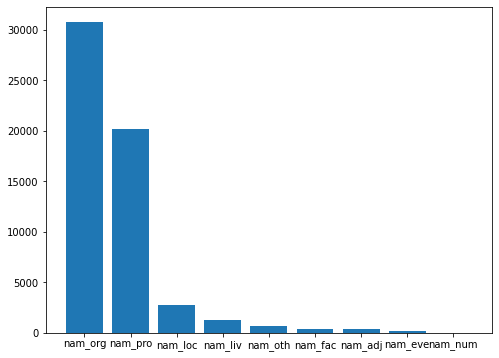

In [91]:
plt.figure(figsize=(8, 6))
plt.bar(list(cg_classes_freq.keys()), list(cg_classes_freq.values()))

### 5. Display 10 most frequent Named Entities for each coarse-grained type.

In [94]:
cg_named_entities_freq = {}
for channel in all_channels:
    for chan in channel.keys():
        cg = chan.split('_')
        cg_class = cg[0] + "_" + cg[1]
        indexes_nes = channel.values()
        cg_named_entities_freq[cg_class] = cg_named_entities_freq.get(cg_class, {})

        for index_ne in indexes_nes:
            for ne in index_ne.values():
                ne_expr = " ".join(ne)
                cg_named_entities_freq[cg_class][ne_expr] = cg_named_entities_freq[cg_class].get(ne_expr, 1) + 1

In [95]:
for cg_class, en_dict in cg_named_entities_freq.items():
    en_dict_sorted = dict(sorted(en_dict.items(), key=lambda x:-x[1]))
    cg_named_entities_freq[cg_class] = en_dict_sorted

In [96]:
for cg_class in cg_named_entities_freq.keys():
    named_entities = list(cg_named_entities_freq[cg_class].keys())[:10]
    print(cg_class)
    for ne in named_entities:
        print("    " + ne + ": " + str(cg_named_entities_freq[cg_class][ne]))
    print("\n")

nam_pro
    Dz . U .: 2553
    Times: 249
    Rzeczypospolitej Polskiej: 192
    Ordynacja podatkowa: 104
    Times New Roman: 98
    Znak: 93
    Dz . Urz: 92
    Monitor Polski: 68
    Kodeksu karnego: 66
    Spraw Wewnętrznych: 56


nam_liv
    Straży Granicznej: 52
    Kasa Chorych: 52
    Kasy Chorych: 30
    Sił Zbrojnych: 27
    Rzeczypospolitej Polskiej: 26
    Art: 24
    Głównego Inspektora: 21
    Pana: 19
    Państwowej Straży Pożarnej: 18
    Dz . U .: 18


nam_org
    Unii Europejskiej: 550
    Państwowej Straży Pożarnej: 474
    Rzeczypospolitej Polskiej: 382
    Skarbu Państwa: 347
    Dz . U .: 347
    Rada Ministrów: 289
    EFTA: 283
    Europejskiego Porozumienia o Wolnym Handlu: 258
    Prezes Rady Ministrów: 248
    Minister Sprawiedliwości: 237


nam_loc
    Rzeczypospolitej Polskiej: 869
    OKRĘG: 106
    Unii Europejskiej: 100
    Dz . U .: 94
    Polsce: 62
    Rzeczpospolita Polska: 60
    Monitor Polski: 58
    EFTA: 50
    Dzienniku Urzędowym Rzeczypospoli

### 6. Display 50 most frequent Named Entities including their count and fine-grained type.

In [104]:
fg_named_entities_freq = {}
for channel in all_channels:
    for fg, indexes_nes in channel.items():
        for index, ne in indexes_nes.items():
            ne_expr = " ".join(ne)
            _, freq = fg_named_entities_freq.get(ne_expr, (fg, 0))
            fg_named_entities_freq[ne_expr] = (fg, freq + 1)

In [105]:
fg_named_entities_freq = dict(sorted(fg_named_entities_freq.items(), key=lambda x:-x[1][1]))

In [106]:
for ne in list(fg_named_entities_freq.keys())[:50]:
    print(ne)
    print("   type: " + fg_named_entities_freq[ne][0])
    print("   frequency: " + str(fg_named_entities_freq[ne][1]))
    print("\n")

Dz . U .
   type: nam_pro_media_periodic
   frequency: 1719


Rzeczypospolitej Polskiej
   type: nam_loc_gpe_country
   frequency: 851


Skarbu Państwa
   type: nam_org_institution
   frequency: 342


Państwowej Straży Pożarnej
   type: nam_org_organization
   frequency: 304


Unii Europejskiej
   type: nam_org_organization
   frequency: 303


Rada Ministrów
   type: nam_org_institution
   frequency: 283


zł
   type: nam_oth_currency
   frequency: 280


Prezes Rady Ministrów
   type: nam_org_institution
   frequency: 235


Minister Sprawiedliwości
   type: nam_org_institution
   frequency: 233


Times
   type: nam_pro_media_periodic
   frequency: 205


Minister Obrony Narodowej
   type: nam_org_institution
   frequency: 156


Minister Finansów
   type: nam_org_institution
   frequency: 151


Urzędu Ochrony Państwa
   type: nam_org_institution
   frequency: 133


Straży Granicznej
   type: nam_org_institution
   frequency: 129


polski
   type: nam_adj_country
   frequency: 115


EFTA


### 7. Answer the following questions:

##### Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?

   Więcej nazw własnych pojawiło się w metodzie NER i pominięte zostały takie słowa jak np. Numer, który pojawił się najwięcej razy w meotdzie counting expressions, ale jest to wada tekstów ustaw, bo normalnie to słowo nie jest pisane z wielkiej litery, jeśli nie jest na początku zdania a te słowa były pomijane. Ponadto metoda counting expressions nie wykryła nazw, w których wystąpił np. spójnik, który zapisany był z małej litery i przerwał ciągłość wyrażenia, a w metodzie NER takie nazwy zostały wykryte np. Minister Zdrowia i Opieki Społecznej.

##### What are the drawbacks of the method based on capital letters?

   Tak jak już wspomniałam, jeśli w nazwie wystąpił np. spójnik pisany od małej litery to nazwa była dzielona na dwie osobne. Ponadto znalazła wyrażenia takie jak Numer czy Rada, które nie są nazwą własną, ale w ustawach często były pisane od wielkiej litery. 
    
##### What are the drawbacks of the method based on NER?

   Brak lemmatyzacji sprawił, że pojawiły się osobno takie nazwy jak Sąd Najwyższy i Sądu Najwyższego. Natomiast w plikach znajduje się też forma bazowa, ale np. w przypadku Dz zostało to rozwinięte jako Dzieje_(Apostolskie), a chodziło o Dziennik. Przetworzenie dużej ilości tekstu jest bardziej czasochłonne w stosunku do pierwszej metody.

##### Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.

   Dobrze zostały zaklasyfikowane typy nam_org (organizacje), nam_num (wyrażenie numeryczne), nam_adj (przymiotniki pochodzące od nazw własnych), nam_oth (waluty, technologie). Średni wynik uzyskały typy takie jak nam_loc (lokalizacje), nam_liv (istoty żywe). Natomiast nam_eve (wydarzenia), nam_fac (konstrukcje), nam_pro (chrematonimy) mają najgorszy rezultat. W nam_pro jeszcze pojawiła się nazwa czcionki, w nam_eve EURO jest ok, jeśli rozumiana jako Mistrzostwa Europy w Piłce Nożnej, ale w nam_fac są same tytułu osób oraz organizacje. Myślę, że te błędy mogą wynikać z faktu, że rzadko używa się nazw własnych w niektórych kontekstach takich jak np. konstrukcje. Raczej ktoś powie pomnik upamiętniający wydarzenie niż wymieni nazwę pomnika. W tych kategoriach, które się pojawiły w najgorszych często posługujemy się określeniami upraszczającymi nazwę własną do zwykłego wyrażenia.

##### Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej") ? If not, can you suggest an algorithm or a tool that would be able to group such names together?

   NER nie nadaje się do takiego zadania. Brakuje w nim lemmatyzacji oraz słownika synonimów, aby grupować tego typu wyrażenia. Korzystaliśmy już z narzędzie WordNet, w którym zawarte są synonimy i mamy dostęp do lemmu.

##### Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?
    
   Wyszukiwarki internetowe - NER przyspieszy wyszukiwanie, jeśli np. skupimy się na zestawie nazw własnych zamiast całej treści. Systemy rekomendacyjne - na podstawie nazw własnych zawartych np. w czytanym przez nas tekście system może podpowiadać kolejne artykułu o podobym zestawie nazw.